# Automated Keyword Extraction from Articles
[Original article here](https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
df = pd.read_csv('../../../data/papers.csv')

Let's first explore the dataframe columns so that we can remove all the papers with missing abstracts (as they do in the article)

In [3]:
print(df.columns)

Index(['id', 'year', 'title', 'event_type', 'pdf_name', 'abstract',
       'paper_text'],
      dtype='object')


In [4]:
df.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


We can already see that missing abstracts look like a string 'Abstract Missing' under the abstract column.

Below, we return all rows of the dataframe for which the value under abstract column is 'Abstract Missing'

In [5]:
df.loc[df['abstract']=='Abstract Missing'].head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


We can very simply take the index of all the papers with missing abstracts and drop those rows from the original dataframe.

In [6]:
idx = df.loc[df['abstract']=='Abstract Missing'].index
df = df.drop(index=idx)
df = df.reset_index(drop=True) #reset index

## Preliminary Text Exploration
The first feature we will create for our abstracts is the word count.

To do so, we will apply a lambda function to each item in the 'abstract' column . This lambda function will implement the `.split()` method of a string, which breaks up the string with a specified 'separator'. In our cases, the separator will be any space between words.

```python
str(item_in_row).split(" ") 
```

Note that without any input, `.split()` will default to splitting by space, and so we put the space in merely for our association. 

This will return a list of each word which has been separated. To get the word count we will simply use the python length function.

In [7]:
#the lambda function we apply will make a list of all the words and then take its len()
df['word_count'] = df['abstract'].apply(lambda x: len(str(x).split(" ")))
df[['abstract','word_count']].head()

,abstract,word_count
0,Non-negative matrix factorization (NMF) has pr...,107
1,Spike-triggered averaging techniques are effec...,81
2,It is known that determinining whether a DEC-P...,67
3,We present the first truly polynomial algorith...,143
4,Semi-supervised inductive learning concerns ho...,119


In [8]:
df.word_count.describe()

count    3924.000000
mean      148.390928
std        45.605755
min        19.000000
25%       116.000000
50%       143.000000
75%       177.000000
max       317.000000
Name: word_count, dtype: float64

We can see that the average word count is ~148 words per abstract, and ranges from a minimum of 19 to a maximum of 317 words.

This information is important as it will give us a sense of how large our dataset is, as well as the variation in word count across each paper. 

### Word Frequency
We will now move on to a second common feature in text mining, **Word Frequency**. Word frequency can be thought of as the number of times a word appears in the text corpus (the set of all text). 

We can calculate word frequency by first turning all of our abstracts into one large string, and then splitting them as we've done previously. 

We can use the `.join(iterable)` function to concatenate strings. We can put any iterable object within the method and it will concatenate (or join) each element to return the joined string. 

We now see that if we join the DataFrame column of our abstracts, followed by splitting it, we will receive a separated list of all words contained in our corpus. 

In [9]:
#create a series of all the words in all the abstracts 
freq = pd.Series(''.join(df['abstract']).split())

Now by wrapping this object in a `pandas.Series()` we gain access to the `Series.value_counts()` function. This function will count each unique value contained in the series. 

Now there is a chance that there will be some slight variations between common words. For instance, the word 'color' and 'colour' will be regarded as different, even though their counts should technically be summed. The same applies to differences in punctuation. Solving these problems is a matter of preprocessing, which we will be exploring soon.

In [10]:
hi_freq = freq.value_counts()[:20]
print('20 most common words in the abstracts')
print('Word \t    Count')
print(hi_freq)

20 most common words in the abstracts
Word 	    Count
the         29793
of          20918
a           16339
and         13626
to          12869
in           8980
that         7838
is           7666
for          7169
on           5579
we           5167
We           4995
with         4512
this         3677
as           3643
are          3529
an           3366
by           3197
can          2953
learning     2825
dtype: int64


In [11]:
low_freq = freq.value_counts()[-20:]
print('20 least common words in the abstracts')
print('Word \t    Count')
print(low_freq)

20 least common words in the abstracts
Word 	    Count
web).                 1
modelling:            1
BBVI                  1
serial,               1
EBP-trained           1
PiCoDes               1
forest,               1
(GAIL)                1
``filter              1
(MPEs)                1
star-convexity        1
markets."The          1
$50\times$            1
grammars.             1
(MH),                 1
learning.Recently,    1
(labels,              1
Perturbed             1
maximum-weight        1
additionally,         1
dtype: int64


At a glance we may think that words which occur with greater frequency are more important, however, tt turns out that knowing both the highest and lowest frequency words has great significance to preprocessing. 

For words which are incredibly low frequency, we may decide to remove them, as they do not appear often enough to discern any meaningful patterns. These words are one-offs, and can even be typos or erratic writing artifacts from the author. In this way we can consider them 'noisy entries' which contribute to unnecessary columns in our matrices and thus unnecessary computation. High frequency words suffer from the opposite. They occur so frequently that they lose all meaning. How much could a word such as 'the', 'to', and 'for' really tell us about our text. 

With this discussion we enter the realm of **Text Preprocessing**.

## Text Pre-processing
With this mild exploration under our belts, we are read to begin the critical preprocessing step. A processed corpus of text will often take the form of a massive matrix which is some interpretation of our word frequency values. Of course, many of these cells will contain zeros as in entirety, very few of our corpus words appear in very few of our corpus entries. 

This is the problem of *matrix sparsity*. For its size, our processed corpus matrix actually has very little information. Luckily, through the act of preprocessing we can minimize its impact on our model.

For this introduction to text mining, we will split text preprocessing into two key steps. 
- **Noise Removal**: Removing data components which are redundant to our text analytics and thus are be considered noise.
- **Normalization**: The process of handling multiple occurences or representations of the same word. Normalization can be further broken down into two types: *stemming* and *lemmatization*. 
 - **Stemming**: Text is normalized texts by removing suffixes and prefixes. i.e. *learned*, *learner*, and *learning* all become *learn*.
 - **Lemmatisation**: A more advanced technique which identifies the *root* of the word. 

To perform these operations, we look to the most common library for NLP workflow, the **Natural Language Toolkit Library**.

Below we import two objects which simplify the process of stemming and lemmatisation, the `PorterStemmer` and `WordNetLemmatizer`. Each is a specific implementation of their underlying process, and it is important to know (and perhaps experiment with) the effects of different types of stemmers and lemmatizers.

In [12]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

lem = WordNetLemmatizer()
stem = PorterStemmer()

word = 'learning'

print("stemming:",stem.stem(word))
print("lemmatization:", lem.lemmatize(word, "v"))

stemming: learn
lemmatization: learn


Change the value of the variable `word` above to gain an understanding of how this process works.

### Import Text Pre-processing libraries
Based on your OS, there are certain subfolders of the NLTK library which may not have been brought to your computer during the command line installation. Luckily, they've thought of this and have included functions to grab these parts.

If this is your first time using nltk, you will have to uncomment the `nltk.download` lines to grab the additional tools.

In [13]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

We now introduce the notion of **Stop Words**. Stop words are essentially any words we consider useless. Like we previously discussed, these would include high frequency words such as 'the','a','an', etc. By removing these words we save space in our database and save valuable compute time. Thus, we use the `stopwords` object to store a list of words which we are to consider redundant. 

The `stopwords` object comes with a default list of stopwords included, but we can also add to this object. As is common practice, we will add our list of most common words to the defaut list.

In [28]:
# create list of stop words and add custom stopwords
stop_words = set(stopwords.words("english"))

No doubt, there will be some overlap between the default words included in `stopwords` and the high frequency words we've found. However this proves to not be an issue as the `stopwords` object is a member of the `set` class. Sets are like lists which do not keep track of order or repeat entries. 

This means we can freely add our most frequently counted words and any doubled words will have no effect. Let's add our 25 most common words to our list of stop words, as well as some custom entries.

In [29]:
print(freq.value_counts()[:25])

the         29793
of          20918
a           16339
and         13626
to          12869
in           8980
that         7838
is           7666
for          7169
on           5579
we           5167
We           4995
with         4512
this         3677
as           3643
are          3529
an           3366
by           3197
can          2953
learning     2825
which        2781
be           2673
from         2622
our          2446
model        2408
dtype: int64


Above we have our 25 most common words. It us up to us as data scientists to build a domain expertise so we can determine when words become relevant to the problem space. Ideally we could perform a more thorough analysis of this list, however for now the purpose of this example we will blindly add the top 25 words to our list of stop words.

In [36]:
#our list of the 25 highest frequency words
new_stop_words = freq.value_counts()[:25].index.values

# create a list of custom stopwords
custom_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]

stop_words = stop_words.union(new_stop_words)
stop_words = stop_words.union(custom_words)

## Creating a Processed Corpus
We will now create a first iteration of our text corpus. Below is a for loop which carries out the following steps.

1. Replace all non-alpha characters with a space using re.sub()
2. Convert the text to lower case
3. Remove possible HTML artifacts by removing any tags with re.sub()
4. Remove special characters and digits with re.sub()
5. Turn the string into a list with .split()
6. Stem the list using PorterStemmer
7. Lemmatize the list using WordNetLemmatizer
8. Concatenate the processed words into one string with spaces between words using ''.join(). This is now a paragraph which is our abstract reconstructed post-processing.
9. Add this paragraph as an entry to our text corpus.

In [37]:
corpus = []

for i in range(len(df)):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df['abstract'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

Let us view an item from our corpus to witness the results of our work.

In [38]:
corpus[11]

'present epoch greedy algorithm multi armed bandit observable side information epoch greedy following property knowledge time horizon necessary regret incurred epoch greedy controlled sample complexity bound hypothesis class regret scale better sometimes much better complexity term sample complexity bound standard supervised'

## Data Exploration
We will now perform the sacred act of data exploration. Unlike the analysis of most variables, text analysis poses a unique challenge as our dataset is composed of entirely unique entities.

As a basic visualization, we will use the `WordCloud` object to visualize the most frequently used words in our cleaned corpus.

In [39]:
from os import path 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

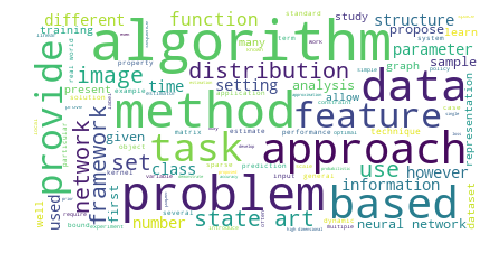

In [40]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
#print(wordcloud)
fig = plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
#fig.savefig("word1.png", dpi=900)

## Text Preparation 
As we still have a corpus which is composed of strings,our data is not yet suited to be trained on by our algorithms. Text in the corpus needs to be converted into a format which can be interpretted by ML. There are two primary parts to this process:
- **Tokenisation**: The process of converting the continuous text into a list of words. We can choose the length of these tokens (i.e. how many words or how many characters are selected).
- **Vectorisation**: The list of words which result from tokenisation is converted into a matrix of integers. This matrix encodes which tokens are present in which text entries using binary 0 and 1 values. 

Our description of vectorisation above is known as the **bag of words model**, which ignores the sequence of words and only considers frequencies. There are other ways to encode text data, such as **Word2Vec**, which is a common method involving creating vector representations of words in a generated vector space. 

### Creating a Vector of Word Counts
To perform vectorisation, we will use the `CountVectoriser` from scikit-learn. This object will perform the tokenisation to build a vocabulary of known words.

When it builds this vocabulary it will consider tokens within a specific range of token lengths. We call this the notion of **ngrams**. An ngram is a token of *n* grams, where a gram (short for grammar) where a gram can be a specified resolution of text data such as characters or words). Thus, a tri-gram with three word-level grams could be a token such as "trigrams are fun.

Below we specify that our ngram range includes unigrams, bigrams, and trigrams. 

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df=0.8,stop_words=stop_words,
                     max_features=10000,
                     ngram_range=(1,3))
#store the data which has been transformed by cv into X
X = cv.fit_transform(corpus)

Let's walk through the parameters we passed into the `CountVectoriser` generator function.
- `max_df`: when building the vocabulary, ignores terms which have a document frequency strictly higher than the given threshold. In our case, we will ignore words which have document frequency above 80%. This ensures we only have relevant words in the corpus and not commonly used ones.
- `max_features`: determines the number of columns in the matrix
- `ngram_range`: specifying (1,3) tells `CountVectoriser` that we want to look at a list of single words, two words, and three word combinations (uni-, bi-, and tri-grams).

Not only have we produced `X`, our *bag of words*, which is our transformed data, we also are able to access useful information that the `CountVectoriser` object has processed, such as a list of the vocabulary.

In [42]:
list(cv.vocabulary_.keys())[:10]

['non',
 'negative',
 'matrix',
 'factorization',
 'nmf',
 'useful',
 'decomposition',
 'multivariate',
 'data',
 'different']

### Visualize Top N-Grams

In [43]:
def get_top_n_words(corpus,n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    
    #list comprehension which unpacks the dictionary in vocabulary_.items() and counts
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    #sort words_freq from largest to smallest by index[1] of each row
    words_freq = sorted(words_freq, key = lambda x: x[1],reverse=True)
    return words_freq[:n]

In [44]:
get_top_n_words(corpus,n=20)

[('algorithm', 4368),
 ('method', 3334),
 ('problem', 3319),
 ('data', 3150),
 ('approach', 2008),
 ('function', 1954),
 ('model', 1922),
 ('based', 1854),
 ('network', 1845),
 ('time', 1488),
 ('paper', 1459),
 ('result', 1403),
 ('task', 1402),
 ('distribution', 1353),
 ('propose', 1351),
 ('state', 1279),
 ('feature', 1254),
 ('image', 1194),
 ('performance', 1180),
 ('bound', 1164)]

Plot of the msot frequently occuring uni-grams


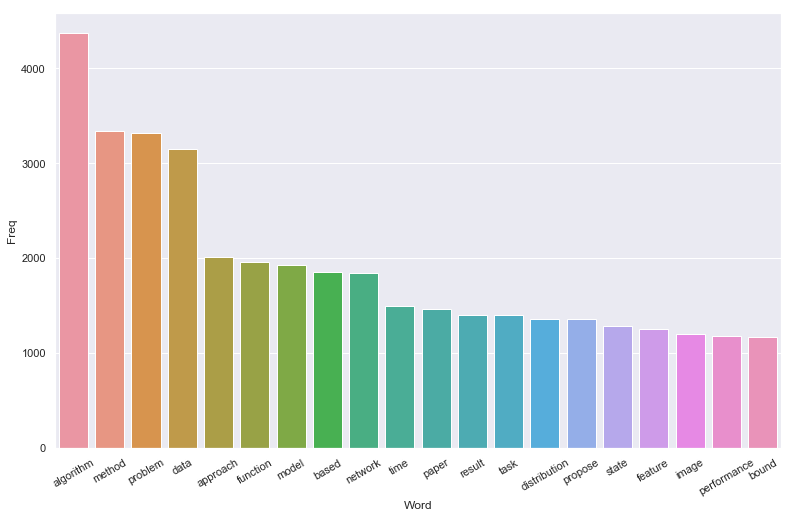

In [45]:
#Create bar plot of most frequent words
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words,columns=['Word','Freq'])

import seaborn as sns
print('Plot of the msot frequently occuring uni-grams')
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30);                    

In [46]:
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

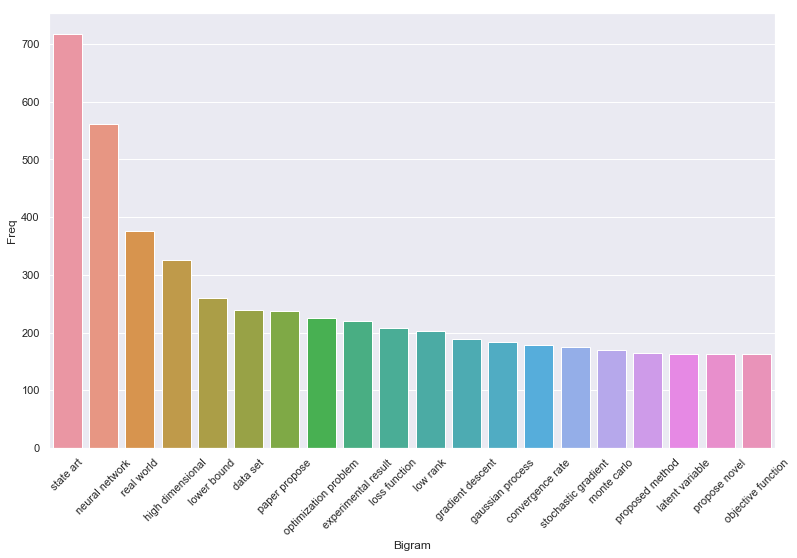

In [47]:
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words,columns=['Bigram','Freq'])

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bigram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45);

In [48]:
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

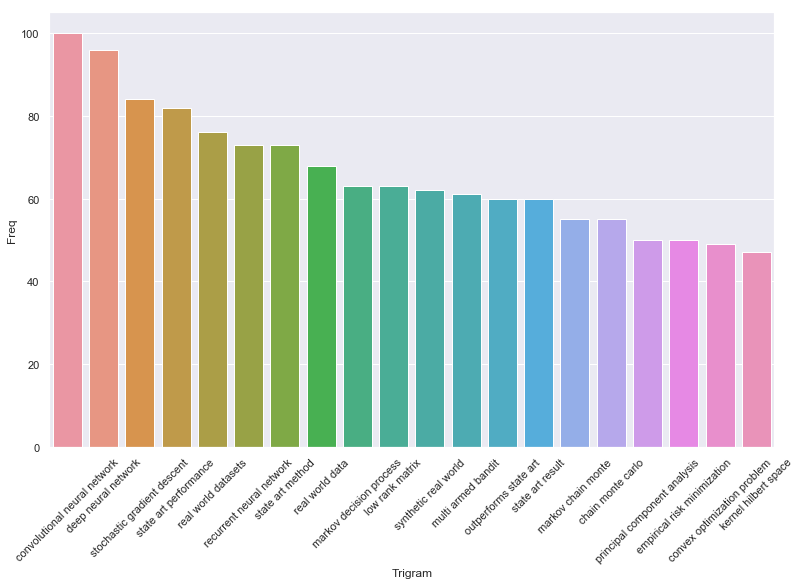

In [49]:
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words,columns=["Trigram",'Freq'])

#Barplot of most freq Tri-grams

sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Trigram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45);

We can already see how we might generate some keywords from the n-grams we have so far.

### Converting to a Matrix
The next step involves using the notion of **TF-IDF** (Term Frequency - Inverse Document Frequency). Both TF and IDF are word frequency scores which highlight words more important to context rather than those which appear across documents. Try to understand how they do so by looking at their formulae below.

- **TF** = term frequency
<center>$TF = \frac{\text{freq of terms in a document}}{\text{total number of terms in a document}}$</center>

- **IDF** = inverse document frequency
<center>$IDF = \frac{\text{log(total documents)}}{\text{# of documents with the term}}$</center>

By incorporating these measures into our evaluation of the corpus, we hope to overcome the deficiency of `countVectoriser`. More specifically, with the `countVectoriser` method, large counts of certain words have the potential to dilute the impact of more context specific words which appear in our corpus. TF-IDF will penalize words which appear several times across the samedocument. 

The `TfidfTransformer` object will implement these two metrics to help bring out context from the corpus.

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
#remember X is our bag of 1-,2-,and 3-grams generated from CountVectoriser
tfidf_transformer.fit(X); 

To illustrate what the output of the TF-IDF transformer looks like, we will transform just a single abstract.

In [54]:
#returns a mapping from the feature integer indices to the name of the feature (ngram)
feature_names = cv.get_feature_names()

#fetch document for which keywords needs to be extracted
doc = corpus[532]

#generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(cv.transform([doc])) 
#note we need to put doc inside a list because transfomer must take an iterable
print(tf_idf_vector)

  (0, 9982)	0.061046816612403965
  (0, 9979)	0.1337091082560646
  (0, 9945)	0.11045888448158363
  (0, 9935)	0.04217094638001401
  (0, 9925)	0.1030059889833844
  (0, 9918)	0.05407367022064083
  (0, 9545)	0.08537380111620914
  (0, 9343)	0.0745474198220887
  (0, 9242)	0.1145146723772313
  (0, 9111)	0.08034907393181975
  (0, 9030)	0.09493008013374031
  (0, 8786)	0.04911886561412257
  (0, 8600)	0.0700851246901378
  (0, 8599)	0.06486087786126522
  (0, 8494)	0.051356339073561755
  (0, 8326)	0.06619656531835388
  (0, 8214)	0.03946221266915964
  (0, 7925)	0.08824763344987241
  (0, 7869)	0.05818422062569449
  (0, 7817)	0.08360740382649084
  (0, 7482)	0.06536094559671411
  (0, 7375)	0.1436828123649399
  (0, 7280)	0.07215469709676481
  (0, 7204)	0.09424771348508444
  (0, 7201)	0.048462604335998194
  :	:
  (0, 3348)	0.0763093068364762
  (0, 3030)	0.10865082984750046
  (0, 3028)	0.05236884149936592
  (0, 2948)	0.15345980174343934
  (0, 2718)	0.11165399703039945
  (0, 2555)	0.06525962033128437
  (0, 

We can see that we have encoded this particular document from the corpus TF-IDF scores. By creating a function to retrieve top scores we can retrieve words which are of top **relevance** to the document. 

What are these words other than the **keywords** we have sought after this whole time!

Let's now create a function to retrieve the top TF-IDF scores for each element in the corpus.

In [55]:
#coo_matrix is a matrix in coordinate format (x,y,z)
from scipy.sparse import coo_matrix

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [57]:
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo()) #we turn the vector into coordinate format

#extract only the top n keywords
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
present theory compositionality stochastic optimal control showing task optimal controller constructed certain primitive primitive feedback controller pursuing agenda mixed proportion much progress making towards agenda compatible agenda present task resulting composite control law provably optimal problem belongs certain class class rather general yet number unique property bellman equation made linear even non linear discrete dynamic give rise compositionality developed special case linear dynamic gaussian noise framework yield analytical solution e non linear mixture linear quadratic regulator without requiring final cost quadratic generally natural set control primitive constructed applying svd green function bellman equation illustrate theory context human arm movement idea optimality compositionality prominent field motor control yet hard reconcile work make possible

Keywords:
compositionality 0.326
primitive 0.292
control 0.255
linear 0.212
controller 0.198


## Create Procedural Functions
Below we create the procedural functions to take any element of our corpus and return a keyword.

In [62]:
def get_keywords(tf_idf, cv, doc, verbose = False):
    vec = tf_idf.transform(cv.transform([doc]))
    sorted_items=sort_coo(vec.tocoo()) #we turn the vector into coordinate format
    keywords=extract_topn_from_vector(feature_names,sorted_items,5)
    
    if verbose:
        print("\nAbstract:")
        print(doc)
        print("\nKeywords:")
        for k in keywords:
            print(k,keywords[k])
    return keywords

In [68]:
doc = corpus[100]
kw = get_keywords(tfidf_transformer,cv,doc,verbose=True)


Abstract:
brain computer interface bcis interaction modality based physiological signal body channel e g muscular activity speech gesture prone error recognition subject intent elegant approach improve accuracy bcis consists verification procedure directly based presence error related potential errp eeg recorded right occurrence error six healthy volunteer subject prior bci experience participated human robot interaction experiment asked mentally move cursor towards target reached within step motor imagination experiment confirms reported presence kind errp interaction errp exhibit first sharp negative peak followed positive peak second broader negative peak m feedback respectively order exploit errp need detect single trial short window following feedback associated response classifier embedded bci achieved average recognition rate correct erroneous single trial respectively furthermore achieved average recognition rate subject intent trying mentally drive cursor result possible simu